# <center><b> Práctica 2 de Laboratorio 5 </b><br><u> Espectroscopía Láser </u></center>

Grupo 1: Trinidad Borrel, Bruno Sivilotti, Agustín Brusco

El propósito de este notebook es estudiar *localmente* los picos de las señales de tensión medidas.

## Imports, formato y definiciones

In [1]:
import os
# Verificación y ubicación (y descarga de archivos en colab)
directory_path = os.getcwd()
folder_name = os.path.basename(directory_path)
if folder_name != 'Datos y código - Práctica 2':
    try:
        os.chdir("/content/Laboratorio_5_Datos/Datos y código - Práctica 2")
    except FileNotFoundError:
        !git clone https://github.com/agustinbrusco/Laboratorio_5_Datos.git
        os.chdir("/content/Laboratorio_5_Datos/Datos y código - Práctica 2")

import numpy as np
import scipy.constants as cte
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize  # Para el coloreo dinamico
# Formato para matplotlib
%matplotlib inline
%config InlineBackend.figure_format='retina'
plt.rcParams['font.family'] = 'serif'
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['figure.dpi'] = 100
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['axes.labelsize'] = 'large'
plt.rcParams['axes.xmargin'] = 0

# Diccionario de prefijos:
# si x_array contiene valores en V, (SCALE['m']*x_array) contiene valores en mV
SCALE = {'m': 1e3, 'μ': 1e6, 'n': 1e9, 'p': 1e12,
         'k': 1e-3, 'M': 1e-6, 'G': 1e-9, 'T': 1e-12}

def tiempo_a_frecuencia(tiempo: np.ndarray,
                        freqs_forzadas: np.ndarray,
                        tiempos_forzados: np.ndarray,
                        ) -> np.ndarray:
    """Transforma un array de tiempos asociados a una señal del haz
    en un array de frecuencias del haz emitido asumiendo
    una relacion de proporcionalidad inversa entre ambas cantidades
    (esto es, el pico que sucede primero queda asociado al pico de
    mayor frecuencia, y viceversa).
    """
    m = -((freqs_forzadas.max() - freqs_forzadas.min())
          / (tiempos_forzados.max() - tiempos_forzados.min()))
    return m*(tiempo - tiempos_forzados.min()) + freqs_forzadas.max()


def lineal(t, a, b):
    return a*t + b

## Carga de Mediciones

Utilizando solo T = 22,5 °C

In [10]:
Temps_arr = np.arange(22.5, 22.75, 0.25)  # °C

# Mediciones sin imán:
times_arr = np.zeros((Temps_arr.size, 2500))  # s
# El 2500 se debe a la cantidad de mediciones que realiza el osciloscopio.
V1 = np.zeros_like(times_arr)  # V
V2 = np.zeros_like(times_arr)  # V

# Mediciones con imán:
times_mag_arr = np.zeros((Temps_arr.size, 2500))  # s
# El 2500 se debe a la cantidad de mediciones que realiza el osciloscopio.
V1_mag = np.zeros_like(times_mag_arr)  # V
V2_mag = np.zeros_like(times_mag_arr)  # V

#Mediciones pitaya:
times_pitaya_arr = np.zeros((2, 1024))  # s
# El 2500 se debe a la cantidad de mediciones que realiza la red pitaya.
V1_pitaya = np.zeros_like(times_pitaya_arr)  # V
V2_pitaya = np.zeros_like(times_pitaya_arr)  # V

for i, temp_tag in enumerate(Temps_arr):
    file = f'pendiente{int(temp_tag*100)}.npy'
    times_arr[i], V1[i], V2[i] = np.load(file)
    file_mag = f'magnet{int(temp_tag*100)}.npy'
    times_mag_arr[i], V1_mag[i], V2_mag[i] = np.load(file_mag)

Temps_arr = np.array([Temps_arr]*2500).T  # reshape por consistencia
# Así definidos, cada fila de cada array se corresponde a la misma medición (temperatura)

#cargo datos de pitaya
for i in range(2):
    file_pitaya = f'pitaya{i}.csv'
    times_pitaya_arr[i], V1_pitaya[i], _, V2_pitaya[i] = np.loadtxt(file_pitaya, skiprows=1, delimiter=",", unpack = True)

## Frecuencias de Transición del $\mathrm{Rb}$

In [11]:
FREQS_RUBIDIO85 = np.array([3.61780000e+08, 3.03573244e+09, 3.77105833e+14, 3.77108868e+14, 3.77256703e+14, 3.77257968e+14, 3.77259738e+14])  # Hz
FREQS_RUBIDIO87 = np.array([8.14500000e+08, 6.83468261e+09, 3.77104391e+14, 3.77105206e+14, 3.77111226e+14, 3.88112040e+14])  # Hz
freqs_rubidio = np.sort(np.concatenate([FREQS_RUBIDIO85, FREQS_RUBIDIO87]))  # Hz
print(*[f"{f*SCALE['G']:.6g} GHz" for f in freqs_rubidio], sep=', ')

0.36178 GHz, 0.8145 GHz, 3.03573 GHz, 6.83468 GHz, 377104 GHz, 377105 GHz, 377106 GHz, 377109 GHz, 377111 GHz, 377257 GHz, 377258 GHz, 377260 GHz, 388112 GHz


## Transformación <u>Local</u> Tiempo -> Frecuencia

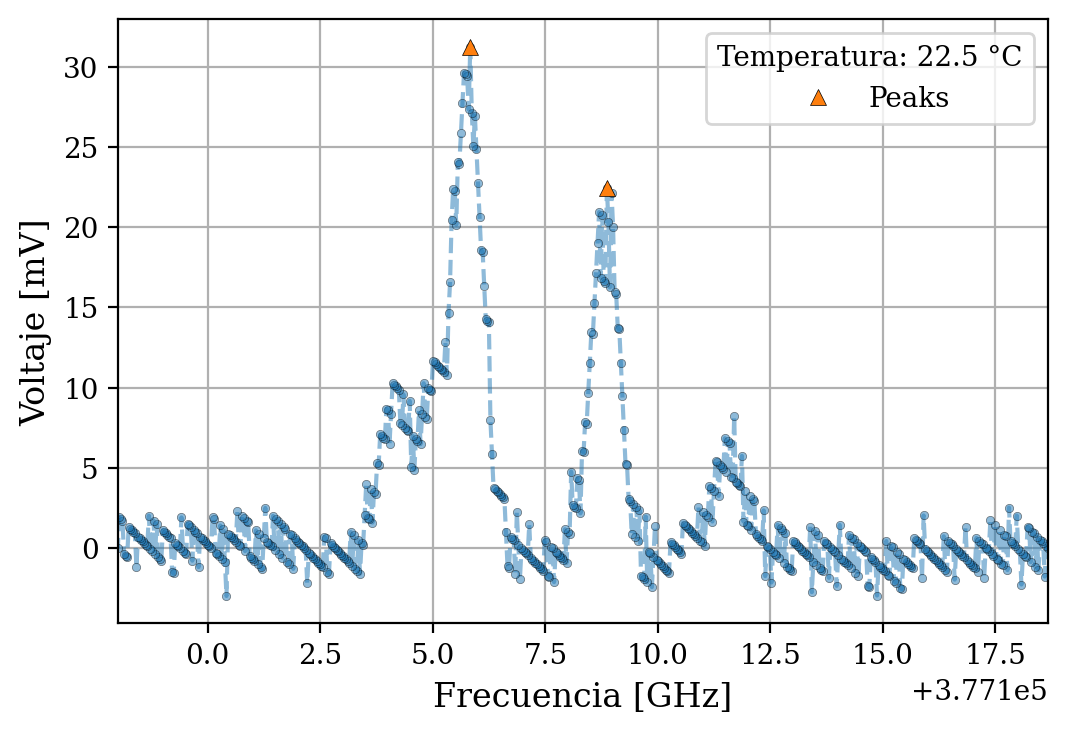

In [30]:
# %matplotlib inline
v_units = 'm'
f_units = 'G'
freqs_arr = np.zeros((1, 600))  # Hz
peaks = [0,]*times_arr.shape[0]  # Indices

for i, temp in enumerate(Temps_arr[:, 0]):
    times = times_arr[i][1000:1600]
    volt1 = V1[i][1000:1600]
    volt2 = V2[i][1000:1600]
    m = (volt1[0] - volt1[-1])/(times[0] - times[-1])
    b = volt1[0] - m*times[0]
    peaks[i] = find_peaks(-(volt1 - lineal(times, m, b)),
                          distance=30, prominence=0.01, height=0.015)[0]
    # Sabemos que estos corresponden com los picos que encontramos con find_peaks:
    idx1 = 6
    idx2 = 7
    freqs_arr[i] = tiempo_a_frecuencia(times,
                                       freqs_rubidio[[idx1, idx2]],  # Hz
                                       times[peaks[i][[-2, -1]]])  # A
    freqs = freqs_arr[i]
    # Plots:
    plt.figure()
    plt.plot(freqs*SCALE[f_units], -(volt1 - lineal(times, m, b))*SCALE[v_units],
             '.--', mec='k', mew=0.25, alpha=0.5)
    plt.plot(freqs[peaks[i]]*SCALE[f_units],  -(volt1 - lineal(times, m, b))[peaks[i]]*SCALE[v_units],
             '^', mec='k', mew=0.25, zorder=10, label="Peaks")
    # plt.plot(SCALE[f_units]*freqs_arr[i],
    #          SCALE[v_units]*volt1,
    #          '.-', ms=3, mec='k', mew=0.25,
    #          zorder=7, label="Sin Imán")
    # plt.plot(SCALE[f_units]*freqs_arr[i][peaks[i]],
    #          SCALE[v_units]*volt1[peaks[i]],
    #          '^', mec='k', mew=0.25, zorder=10)
    # plt.axvline(SCALE[f_units]*freqs_arr[i][peaks[i][-1]],
    #             ls='--', c='C0', zorder=4)
    # plt.axvline(SCALE[f_units]*freqs_arr[i][peaks[i][-2]],
    #             ls='--', c='C0', zorder=4)
    plt.grid(True)
    plt.legend(title=f"Temperatura: {temp} °C")
    plt.ylabel(f"Voltaje [{v_units}V]")
    # plt.xlim(SCALE[f_units]*freqs_arr[i][peaks[i][-1]] -10 , SCALE[f_units]*freqs_arr[i][peaks[i][-2]]+10 )
    plt.xlabel(f"Frecuencia [{f_units}Hz]")
    plt.show()

peaks = np.array(peaks)